In [2]:
import numpy as np 
import pandas as pd
import random
import os
import glob as gb
import cv2
import shutil
import seaborn as sns 
import matplotlib.pyplot as plt
import math
import time
import copy
from pathlib import Path

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import  classification_report, confusion_matrix, accuracy_score


from tensorflow.keras.optimizers import Adam

In [3]:
%config Completer.use_jedi = False

In [4]:
from PIL import Image
from skimage.morphology import closing, disk, opening

In [5]:
import tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [6]:
dataset_folder_pth = '../input/cottonweedid15/CottonWeedID15/'

subfolders = os.listdir(dataset_folder_pth)
subfolders

['Nutsedge',
 'Sicklepod',
 'Morningglory',
 'Ragweed',
 'PalmerAmaranth',
 'Waterhemp',
 'Crabgrass',
 'Swinecress',
 'Prickly Sida',
 'Carpetweeds',
 'SpottedSpurge',
 'SpurredAnoda',
 'Eclipta',
 'Goosegrass',
 'Purslane']

In [7]:
# get a list of image folders
folder_list = os.listdir(dataset_folder_pth)

total_images = 0

# loop through each folder
for folder in folder_list:
    # set the path to a folder
    path = '../input/cottonweedid15/CottonWeedID15/' + str(folder)
    # get a list of images in that folder
    images_list = os.listdir(path)
    # get the length of the list
    num_images = len(images_list)
    
    total_images = total_images + num_images
    # print the result
    print(str(folder) + ':' + ' ' + str(num_images))
    
print('\n')
# print the total number of images available
print('Total Images: ', total_images)

Nutsedge: 273
Sicklepod: 240
Morningglory: 1115
Ragweed: 129
PalmerAmaranth: 689
Waterhemp: 451
Crabgrass: 111
Swinecress: 72
Prickly Sida: 129
Carpetweeds: 763
SpottedSpurge: 234
SpurredAnoda: 61
Eclipta: 254
Goosegrass: 216
Purslane: 450


Total Images:  5187


In [5]:
# Create a new directory to store all available images
all_images_dir = 'all_images_dir'
os.mkdir(all_images_dir)

In [6]:
# This code copies all images from their seperate folders into the same 
# folder called all_images_dir.


folder_list = os.listdir('../input/cottonweedid15/CottonWeedID15')

for folder in folder_list:
    
    # create a path to the folder
    path = '../input/cottonweedid15/CottonWeedID15/' + str(folder)

    # create a list of all files in the folder
    file_list = os.listdir(path)

    # move the 0 images to all_images_dir
    for fname in file_list:

        # source path to image
        src = os.path.join(path, fname)
        
        # Change the file name because many images have the same file name.
        # Add the folder name to the existing file name.
        new_fname = str(folder) + '_' + fname
        
        # destination path to image
        dst = os.path.join(all_images_dir, new_fname)
        # copy the image from the source to the destination
        shutil.copyfile(src, dst)

In [7]:
# Check how many images are in all_images_dir.
# Should be 5187.

len(os.listdir('all_images_dir'))

5187

## Create a dataframe containing all the information

In [9]:
image_dir = Path('../input/cottonweedid15/CottonWeedID15')

# Get filepaths and labels
filepaths_jpg = list(image_dir.glob(r'**/*.jpg'))
filepaths_png = list(image_dir.glob(r'**/*.JPG'))


filepaths_1 = pd.Series(filepaths_jpg, name='Filepath').astype(str)
filepaths_2 = pd.Series(filepaths_png, name='Filepath').astype(str)
filepaths = filepaths_1.append(filepaths_2,ignore_index=True)

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
labels = pd.Series(labels, name='Label')

# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)

# Shuffle the DataFrame and reset index
image_df = image_df.reset_index(drop = True)

In [10]:
# Show the result
image_df.head(3)

,Filepath,Label
0,../input/cottonweedid15/CottonWeedID15/Nutsedg...,Nutsedge
1,../input/cottonweedid15/CottonWeedID15/Nutsedg...,Nutsedge
2,../input/cottonweedid15/CottonWeedID15/Nutsedg...,Nutsedge


In [11]:
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4975 entries, 0 to 4974
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filepath  4975 non-null   object
 1   Label     4975 non-null   object
dtypes: object(2)
memory usage: 77.9+ KB


In [12]:
print(len(image_df))

4975


In [13]:
image_df['Label'].value_counts()

Morningglory      1094
Carpetweeds        763
PalmerAmaranth     689
Purslane           436
Waterhemp          363
Nutsedge           245
Sicklepod          240
SpottedSpurge      216
Eclipta            216
Goosegrass         212
Ragweed            129
Prickly Sida       128
Crabgrass          111
Swinecress          72
SpurredAnoda        61
Name: Label, dtype: int64

<AxesSubplot:xlabel='Label', ylabel='count'>

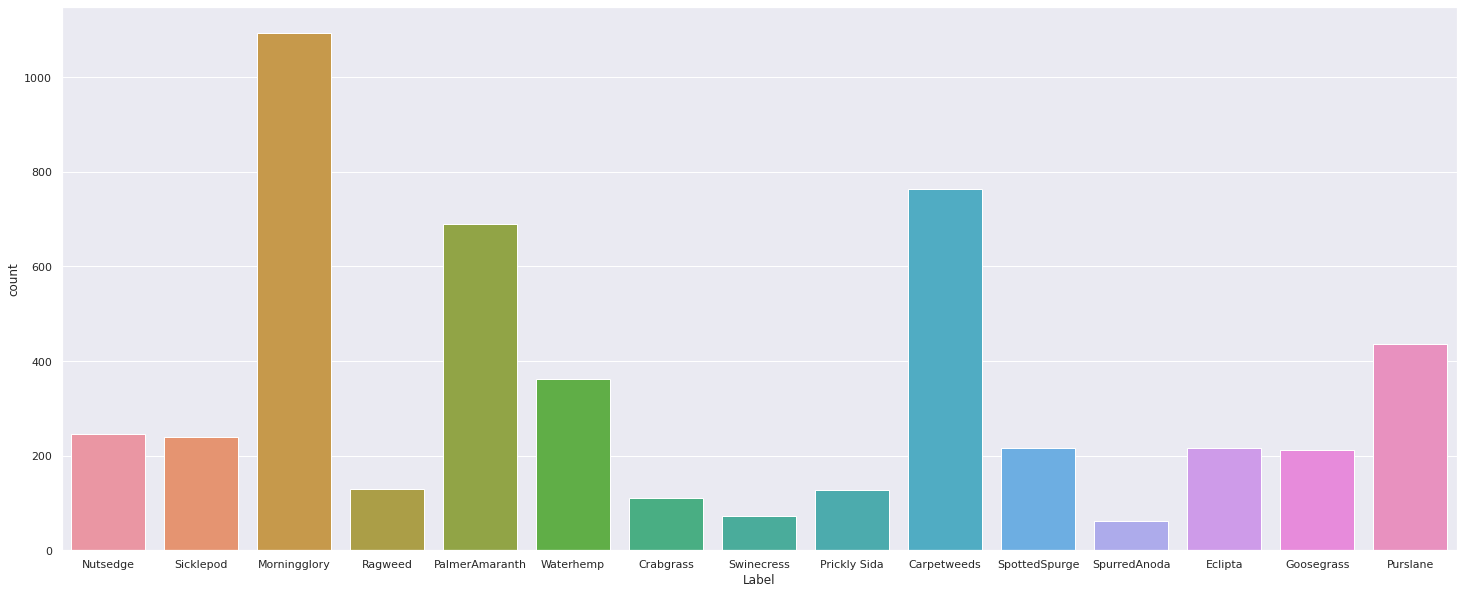

In [56]:
sns.set(rc={'figure.figsize':(25,10)})
sns.countplot(data=image_df, x="Label")

In [57]:
example_path = dataset_folder_pth + "/Nutsedge/06b653426f4447dfaef0404af57f418b__nutsedge__0.jpg" 

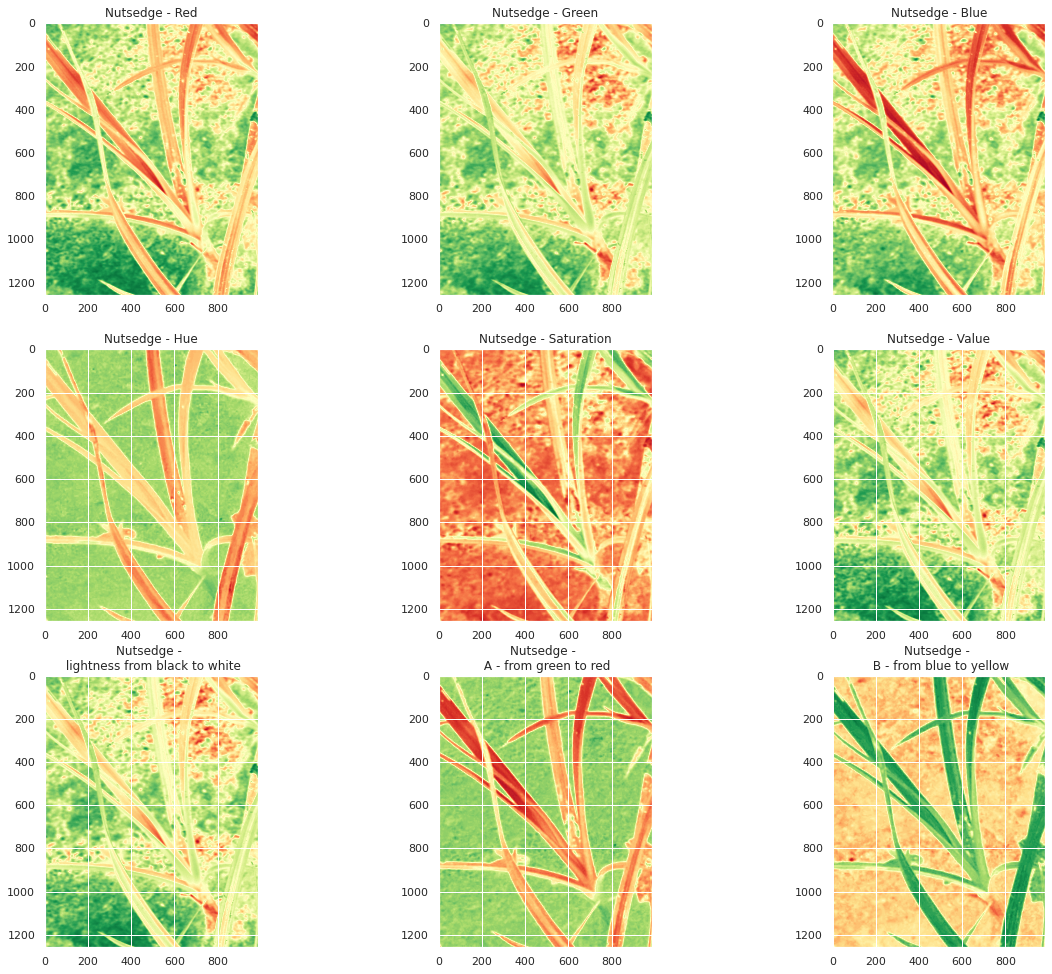

In [58]:
fig,ax = plt.subplots(3,3,figsize=(20,17))

titles = [["Red", "Green", "Blue"],
         ["Hue", "Saturation", "Value"],
         ["\n lightness from black to white", "\n A - from green to red", "\n B - from blue to yellow"]]
pil_image = Image.open(example_path)
np_image = np.array(pil_image)
image_hvs = cv2.cvtColor(np_image, cv2.COLOR_BGR2HSV)
image_lab = cv2.cvtColor(np_image, cv2.COLOR_BGR2LAB)

for n in range(3):
    ax[0,n].imshow(np_image[:,:,n], cmap="RdYlGn")
    ax[0,n].grid(False)
    ax[0,n].set_title("Nutsedge" + " - " + titles[0][n]);
    ax[1,n].imshow(image_hvs[:,:,n], cmap="RdYlGn")
    ax[1,n].set_title("Nutsedge" + " - " + titles[1][n]);
    ax[2,n].imshow(image_lab[:,:,n], cmap="RdYlGn")
    ax[2,n].set_title("Nutsedge" + " - " + titles[2][n]);
plt.savefig("Colorspace", dpi=500)

In [59]:
my_threshold = 121
my_radius = 2

In [60]:
def get_mask(image, threshold, radius):
    mask = np.where(image < threshold, 1, 0)
    selem = disk(radius)
    mask = closing(mask, selem)
    return mask

In [61]:
def segment_plant(np_image, threshold, radius):
#     cv2.cvtColor() method is used to convert an image from one color space to another. There are more than 150 color-space conversion methods available in OpenCV
    image_lab = cv2.cvtColor(np_image, cv2.COLOR_BGR2LAB)
    mask = get_mask(image_lab[:,:,1], threshold, radius)
    masked_image = np_image.copy()
    for n in range(3):
        masked_image[:,:,n] = np_image[:,:,n] * mask
    return masked_image

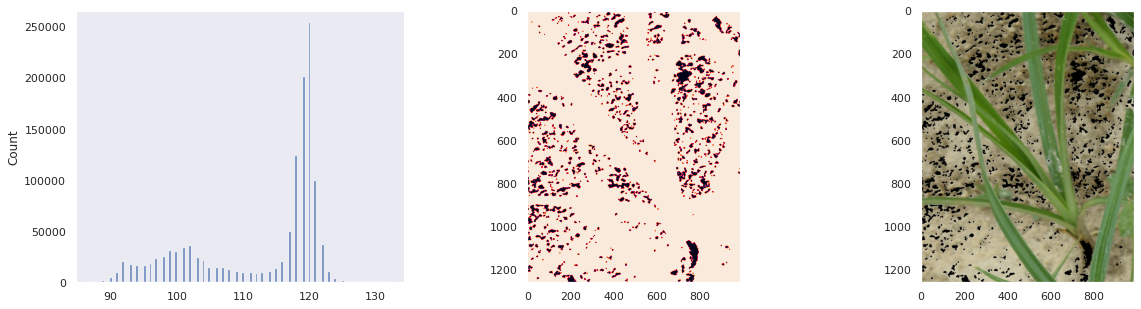

In [62]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.histplot(image_lab[:,:,1].flatten(), ax=ax[0], kde=False)
mask = get_mask(image_lab[:,:,1], my_threshold, my_radius)
ax[1].imshow(mask);
ax[2].imshow(segment_plant(np_image, my_threshold, my_radius))
ax[0].grid(False)
ax[1].grid(False)
ax[2].grid(False)

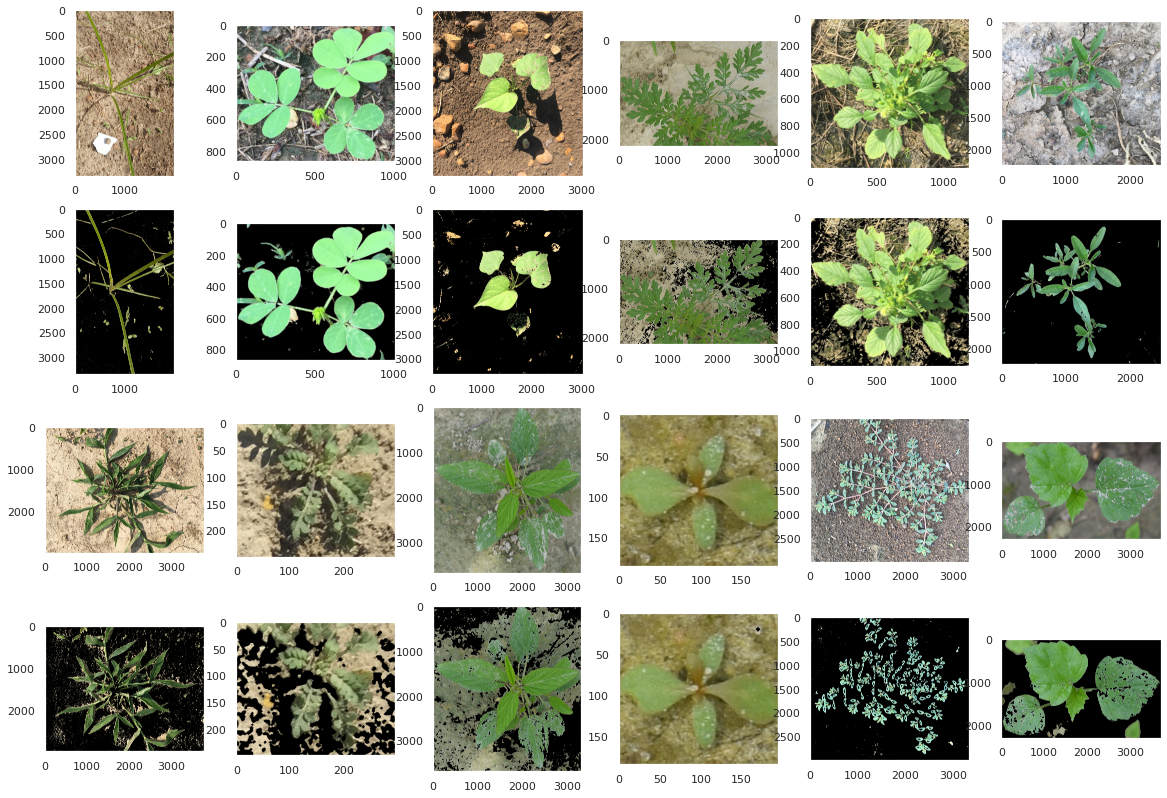

In [63]:
fig, ax = plt.subplots(4,6,figsize=(20,14))

for m in range(6):
    folder = subfolders[m]
    files = os.listdir(dataset_folder_pth + folder + "/")
    image = np.array(Image.open(dataset_folder_pth + folder + "/" + files[0]))
    ax[0,m].imshow(image)
    ax[1,m].imshow(segment_plant(image, my_threshold, my_radius))
    ax[0,m].grid(False)
    ax[1,m].grid(False)

    
    folder = subfolders[m+6]
    files = os.listdir(dataset_folder_pth + folder + "/")
    image = np.array(Image.open(dataset_folder_pth + folder + "/" + files[0]))
    ax[2,m].imshow(image)
    ax[3,m].imshow(segment_plant(image, my_threshold, my_radius))
    ax[2,m].grid(False)
    ax[3,m].grid(False)


In [14]:
# train_test_split

# stratify=y creates a balanced validation set.
y = image_df['Label']

df_train, df_val = train_test_split(image_df, test_size=0.20, random_state=101, stratify=y)

print(df_train.shape)
print(df_val.shape)

(3980, 2)
(995, 2)


In [65]:
df_train.head()

,Filepath,Label
4001,../input/cottonweedid15/CottonWeedID15/Carpetw...,Carpetweeds
4699,../input/cottonweedid15/CottonWeedID15/Purslan...,Purslane
3764,../input/cottonweedid15/CottonWeedID15/Waterhe...,Waterhemp
3072,../input/cottonweedid15/CottonWeedID15/Morning...,Morningglory
3616,../input/cottonweedid15/CottonWeedID15/Waterhe...,Waterhemp


In [66]:
# Train set class distribution

df_train['Label'].value_counts()

Morningglory      875
Carpetweeds       610
PalmerAmaranth    551
Purslane          349
Waterhemp         290
Nutsedge          196
Sicklepod         192
Eclipta           173
SpottedSpurge     173
Goosegrass        170
Ragweed           103
Prickly Sida      102
Crabgrass          89
Swinecress         58
SpurredAnoda       49
Name: Label, dtype: int64

In [67]:
df_val.head()

,Filepath,Label
351,../input/cottonweedid15/CottonWeedID15/Morning...,Morningglory
341,../input/cottonweedid15/CottonWeedID15/Morning...,Morningglory
2438,../input/cottonweedid15/CottonWeedID15/Sicklep...,Sicklepod
4640,../input/cottonweedid15/CottonWeedID15/Purslan...,Purslane
2038,../input/cottonweedid15/CottonWeedID15/Carpetw...,Carpetweeds


In [68]:
# Val set class distribution

df_val['Label'].value_counts()

Morningglory      219
Carpetweeds       153
PalmerAmaranth    138
Purslane           87
Waterhemp          73
Nutsedge           49
Sicklepod          48
Eclipta            43
SpottedSpurge      43
Goosegrass         42
Prickly Sida       26
Ragweed            26
Crabgrass          22
Swinecress         14
SpurredAnoda       12
Name: Label, dtype: int64

# Set Up the Generators

In [15]:
def create_generator():
    # Load the Images with a generator and Data Augmentation
    data_generator = ImageDataGenerator(
        rescale=1.0/255,
        validation_split=0.1
    )


    train_gen = data_generator.flow_from_dataframe(
        dataframe=df_train,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True
    )

    val_gen = data_generator.flow_from_dataframe(
        dataframe=df_train,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
        rotation_range=30, # Uncomment to use data augmentation
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True
    )

    test_gen = data_generator.flow_from_dataframe(
        dataframe=df_val,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return data_generator,train_gen,val_gen,test_gen

In [16]:
datagen, train_gen, val_gen, test_gen = create_generator()

Found 3582 validated image filenames belonging to 15 classes.
Found 398 validated image filenames belonging to 15 classes.
Found 995 validated image filenames belonging to 15 classes.


# Create the Model Architecture

In [1]:

# CNN structure parameters
kernel_size = (3,3)
pool_size= (2,2)

dropout_conv = 0.3
dropout_dense = 0.3


model = Sequential()
model.add(Conv2D(32, kernel_size, activation = 'relu', input_shape=(224, 224, 3)))
model.add(Conv2D(32, kernel_size, activation = 'relu'))
model.add(MaxPooling2D(pool_size = pool_size)) 
model.add(Dropout(dropout_conv))

model.add(Conv2D(64, kernel_size, activation ='relu'))
model.add(Conv2D(64, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Conv2D(64, kernel_size, activation ='relu'))
model.add(Conv2D(64, kernel_size, activation ='relu'))
model.add(MaxPooling2D(pool_size = pool_size))
model.add(Dropout(dropout_conv))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(dropout_dense))
model.add(Dense(15, activation = "softmax"))

model.summary()

NameError: name 'Sequential' is not defined

# Train the Model

In [18]:
model.compile(Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [19]:
checkpoint = ModelCheckpoint(filepath='/kaggle/working/Best_model.h5', monitor='val_loss', verbose=0, 
                             save_best_only=True, mode='min')

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=3, 
                                   verbose=1, mode='max', min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_loss', patience=2,  
                           mode='auto', 
                           restore_best_weights=True)
                                 
callbacks_list = [checkpoint, reduce_lr]

In [20]:
 history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=40,
                    callbacks=callbacks_list)

2022-10-31 06:28:28.936280: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-10-31 06:28:35.494706: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


112/112 [==============================] - 630s 6s/step - loss: 2.4269 - accuracy: 0.2052 - val_loss: 2.5063 - val_accuracy: 0.2613
Epoch 2/40
112/112 [==============================] - 521s 5s/step - loss: 2.2869 - accuracy: 0.2418 - val_loss: 2.2419 - val_accuracy: 0.3166
Epoch 3/40
112/112 [==============================] - 533s 5s/step - loss: 2.1553 - accuracy: 0.3085 - val_loss: 2.0879 - val_accuracy: 0.3668
Epoch 4/40
112/112 [==============================] - 478s 4s/step - loss: 2.0056 - accuracy: 0.3601 - val_loss: 1.9648 - val_accuracy: 0.4271
Epoch 5/40
112/112 [==============================] - 471s 4s/step - loss: 1.8995 - accuracy: 0.3961 - val_loss: 1.8774 - val_accuracy: 0.4171
Epoch 6/40
112/112 [==============================] - 468s 4s/step - loss: 1.7909 - accuracy: 0.4190 - val_loss: 1.7280 - val_accuracy: 0.4497
Epoch 7/40
112/112 [==============================] - 466s 4s/step - loss: 1.6644 - accuracy: 0.4562 - val_loss: 1.7125 - val_accuracy: 0.4472
Epoch 8/40